In [1]:
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.betaVAE_model import vae_model
from src.lstm_mapper3D_model import mapper3D_model
from src.classes import Boundary, TankProperties32x2, BallAnomaly
from src.util import (
    seq_data, 
    load_exp_data3D,
    voxel_ball, 
    plot_voxel_c
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.decomposition import PCA

2025-02-05 13:02:46.847484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738760566.862644  758560 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738760566.868384  758560 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 13:02:46.887307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1738760576.182038  758560 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

## Load Data

In [2]:
def plot_pca(V, angle, title, n_components=2, figsize=(10,8)):
    
    fig, ax = plt.subplots(figsize=figsize)
    original_shape = V.shape
    V_reshaped = V.reshape(V.shape[0], -1)
    pca = PCA(n_components=n_components)
    V_pca = pca.fit_transform(V_reshaped)

    angle_normalized = (angle - np.min(angle)) / (np.max(angle) - np.min(angle))
    
    scatter = ax.scatter(V_pca[:, 0], V_pca[:, 1], c=angle_normalized, cmap='viridis')
    ax.set_title(title)
    
    ax.set_title(title)
    ax.set_xlabel('Hauptkomponente 1 (PC1)')
    ax.set_ylabel('Hauptkomponente 2 (PC2)')
    ax.set_aspect('equal') 
    
    return fig, pca

def transform_position(position):
    
    # Zentriere nur x und y basierend auf erstem Punkt
    center_offset = np.array([position[0,0], position[0,1], 0])  # Z-Offset ist 0
    position_centered = position - center_offset
    
    # Skalierungsfaktoren
    scale_factor = 32/194 #für x,y 
    scale_z = 24/140 #für z
    
    position_centered[:,0] = position_centered[:,0] * scale_factor
    position_centered[:,1] = position_centered[:,1] * scale_z
    position_centered[:,2] = position_centered[:,2] * scale_z

    # x und y um (16,16) zentrieren und Höhe auf 8 angepasst (zentriert um die mittelere Höhe des Tanks)
    position_centered[:,0] = position_centered[:,0] + 16
    position_centered[:,1] = position_centered[:,1] + 16
    position_centered[:,2] = position_centered[:,2] + 8
    
    return position_centered[1:]

def create_gamma(position):
    boundary = Boundary()
    gamma = list()
    diameter_labels = list()
    pos_ball = list()
    vol_ball = list()

    perm = 1
    d = 7

    for i, (x, y, z) in enumerate(position):
        ball = BallAnomaly(x, y, z, d, perm) 
        vxl_ball = voxel_ball(ball, boundary)
                
        gamma.append(vxl_ball)
        diameter_labels.append(d)  
        pos_ball.append([ball.y, ball.x, ball.z])
        vol_ball.append(np.where(vxl_ball == 1)[0].shape[0])

    gamma = np.array(gamma) / 2
    diameter_labels = np.array(diameter_labels)
    pos_ball = np.array(pos_ball)
    vol_ball = np.array(vol_ball)

    return gamma, diameter_labels, pos_ball, vol_ball

def load_3Ddata(file_name, use_mean= False):
    
    print("Loading experimental data...")
    voltage, _, _, position = load_exp_data3D(file_name)
    
    voltage_abs = np.abs(voltage) #absolutwert berechnen
    #fig, pca_fitted = plot_pca(voltage[:,1,:,:], position, "PCA der Spannungsdaten")
    #plt.show()
    
    #z-score normalization
    voltage_normalized = (voltage_abs - np.mean(voltage_abs)) / np.std(voltage_abs)

    voltage_diff = voltage_normalized - voltage_normalized[0] #substraktion von ersten messung (leere Tankmessung)
    voltage_diff = voltage_diff[1:]  # erste Messung "wegwerfen"

    #use mean oder alle Messungen (burst counts) einzeln
    if use_mean:
        print("Calculating mean of voltage differences...")
        voltage_diff = np.mean(voltage_diff, axis=1)
    
    # Transformiere Positionsdaten (d.h. auf 32x32x32 Raum anpassen)
    print("Transforming position data...")
    trans_pos = transform_position(position)
    
    # Erstelle Gamma
    print("Creating gamma...")
    gamma, _, _, _ = create_gamma(trans_pos)
    
    if use_mean:
        print("Processing sequences with mean...")
        voltage_seq, gamma_seq = seq_data(voltage_diff, gamma, n_seg=4)
    else:
        print("Processing sequences for each measurement...")
        voltage_sequences = []
        gamma_sequences = []
        
        for idx in tqdm(range(5), desc="Processing measurement sequences"):
            v_seq, g_seq = seq_data(voltage_diff[:, idx, :, :], gamma, n_seg=4)
            voltage_sequences.append(v_seq)
            gamma_sequences.append(g_seq)
            
        print("Concatenating sequences...")
        voltage_seq = np.concatenate(voltage_sequences, axis=0)
        gamma_seq = np.concatenate(gamma_sequences, axis=0)
    
    print("Data loading complete!")
    return voltage_seq, gamma_seq

In [3]:
voltage, gamma = load_3Ddata("exp_data_3D18")

Loading experimental data...
Transforming position data...
Creating gamma...
Processing sequences for each measurement...


Processing measurement sequences: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Concatenating sequences...
Data loading complete!


In [4]:
print(voltage.shape)

(55980, 4, 64, 64)


In [5]:
print(gamma.shape)

(55980, 32, 32, 32)


In [6]:
total_samples = voltage.shape[0]
split_idx = int(total_samples * 0.8)  # 80% Training (d.h. die ersten 4 burst counts), 20% Test (der letzte (5.) burst count)

voltage_train = voltage[:split_idx]
voltage_test = voltage[split_idx:]

gamma_train = gamma[:split_idx]
gamma_test = gamma[split_idx:]

print(f"Voltage Train: {voltage_train.shape}")
print(f"Voltage Test: {voltage_test.shape}")
print(f"Gamma train: {gamma_train.shape}")
print(f"Gamma test: {gamma_test.shape}")

Voltage Train: (44784, 4, 64, 64)
Voltage Test: (11196, 4, 64, 64)
Gamma train: (44784, 32, 32, 32)
Gamma test: (11196, 32, 32, 32)


## Loading VAE Model and generating labels

In [7]:
beta =  1.04
vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.build(input_shape=(32, 32, 32, 1))
vae.load_weights("weights/3Dvae_best.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [8]:
_, _, latent_rep = vae.encoder.predict(gamma_train)

1400/1400 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step


Original...


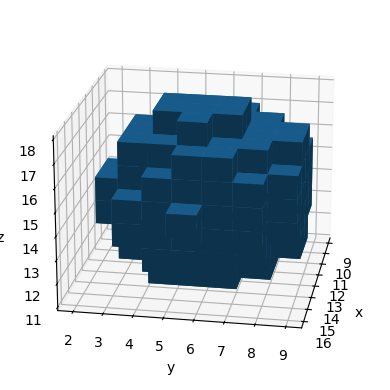

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


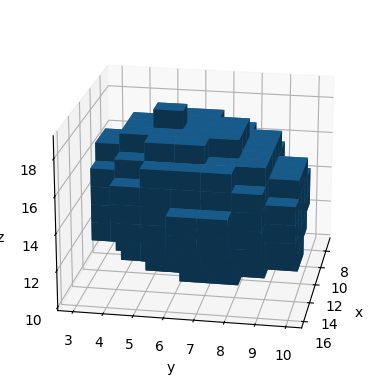

Original...


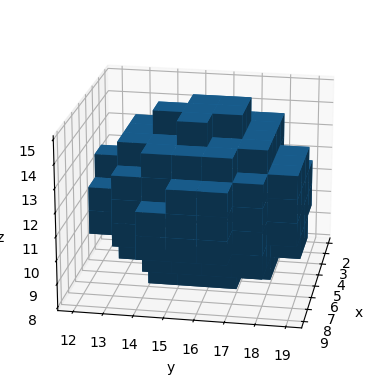

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


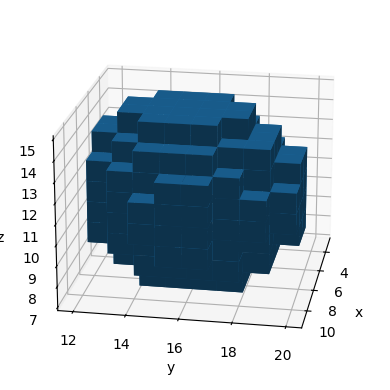

Original...


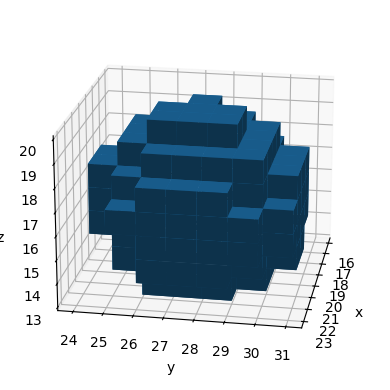

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


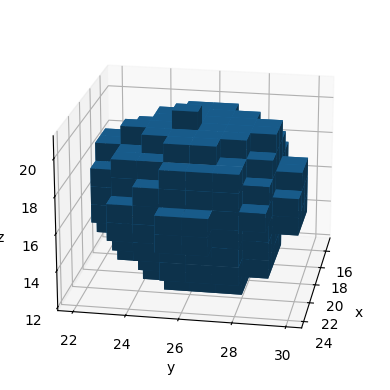

Original...


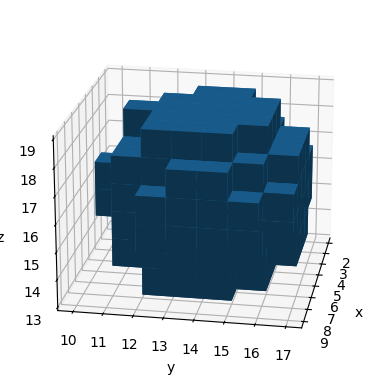

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


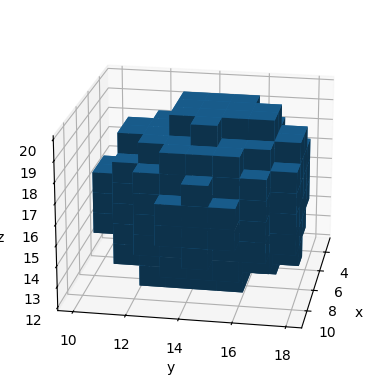

Original...


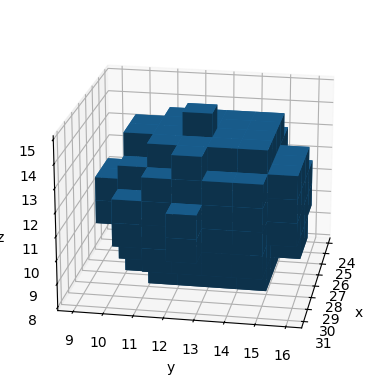

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


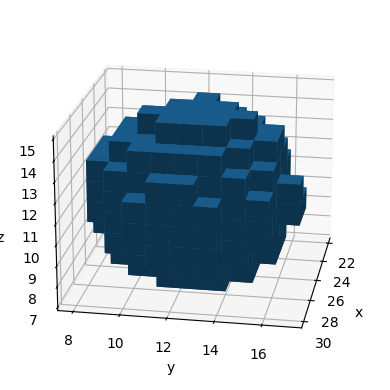

In [9]:
#Test, ob der VAE auch tut was er tun soll...
plt.style.use("default")
for rdn in np.random.randint(low=0, high=gamma.shape[0], size=5):
    print("Original...")
    plot_voxel_c(gamma[rdn, ...])

    print("Prediction...")
    _, _, z = vae.encoder.predict(np.expand_dims(gamma[rdn, ...], 0))
    sgl_pred = vae.decoder.predict(z)
    sgl_pred = np.squeeze(sgl_pred, axis=4)
    sgl_pred = np.squeeze(sgl_pred, axis=0)
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    plot_voxel_c(sgl_pred)

## LSTM Mapper Training

In [10]:
(
    v_train_seq,
    v_test_seq,
    gamma_train,
    gamma_test,
    z_train,
    z_test,
) = train_test_split(
    voltage_train,
    gamma_train,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [11]:
print(v_train_seq.shape)

(40305, 4, 64, 64)


In [12]:
lstm_mapper = mapper3D_model()
lstm_mapper.summary()
lstm_mapper.compile(optimizer="adam", loss="mse")

Model: "lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4, 64, 64, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 4, 31, 31, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 15, 15, 2)   │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 4, 450)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 4, 64)          │        28,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,610 (174.26 KB)

 Trainable params: 44,610 (174.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_mapper = lstm_mapper.fit(v_train_seq, z_train, epochs=100, batch_size = 32, validation_split = 0.1)

Epoch 1/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0429 - val_loss: 0.0013
Epoch 2/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 9.7535e-04 - val_loss: 8.9759e-04
Epoch 5/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 9.4231e-04 - val_loss: 9.3490e-04
Epoch 6/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 9.1957e-04 - val_loss: 8.8862e-04
Epoch 7/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 9.1700e-04 - val_loss: 8.6296e-04
Epoch 8/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 8.9648e-04 - val_loss: 8.6607e-04
Epoch 9/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 8.8916e-04 - val_loss: 8.4101e-04
Epoch 10/100
 589/1134 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 8.6289e-04

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "lstm_eight_Florium_exp.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

In [ ]:
lstm_mapper.load_weights("weights/lstm_eight_Florium_exp.weights.h5")
print("Gewichte erfolgreich geladen.")

## Load Test-Data

In [ ]:
folder_paths = ["exp_data42"]
voltage_test_seq, gamma_true_test = load_and_concatenate_data(folder_paths, seq_data, n_seg=4)

In [ ]:
pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred_test = vae.decoder.predict(pred_latent).reshape(-1, 2840)

In [ ]:
from src.performance_eval_2D import (compute_evaluation_metrics,
    plot_random_deviations, 
    plot_random_recon_examples, 
    plot_deviations_x_y,
    plot_deviations_perm,
    merge_plots_to_pdf,
    run_deviation_analysis)
    

In [ ]:
plot_random_deviations(mesh_obj, gamma_true_test, gamma_pred_test, num_samples=10, threshold=0.5, save=True, fpath='Abbildungen/',
                      fname='random_deviations_circle_interpol_sim_02_08.pdf')

In [ ]:
fig = plot_random_recon_examples(mesh_obj, gamma_true_test, gamma_pred_test, 
                               num_samples=20,
                               save=True, 
                               fpath='Abbildungen/',
                               fname='random_reconstructions_circle_interpol_sim_02_08.pdf')

In [ ]:
def plot_sequence_recon_examples(mesh_obj, true_perm, pred_perm, num_plots=20,
                               save=False, fpath='', fname=''):
    """
    Plot reconstruction examples in sequence with automatically adjusted step size.
    
    Parameters:
    -----------
    mesh_obj : mesh object
        The mesh object containing node and element information
    true_perm : array
        True permittivity values
    pred_perm : array
        Predicted permittivity values
    num_plots : int
        Number of plots to generate (default: 20)
    save : bool
        Whether to save the plots
    fpath : str
        File path for saving
    fname : str
        File name for saving
    """
    # Calculate total available indices
    total_samples = len(true_perm)
    
    # Calculate step size to cover the whole range with num_plots
    # We use max(1, ...) to ensure step_size is at least 1
    step_size = max(1, (total_samples - 1) // (num_plots - 1))
    
    # Calculate indices to plot
    # Using linspace to ensure we get exactly num_plots points including start and end
    indices = np.linspace(0, total_samples - 1, num_plots).astype(int)
    
    # Calculate rows and columns for subplot grid
    cols = 5
    rows = (num_plots + cols - 1) // cols  # Ceiling division
    
    fig = plt.figure(figsize=(4*cols, 4*rows))
    
    pts = mesh_obj.node
    tri = mesh_obj.element
    x, y = pts[:, 0], pts[:, 1]
    
    # Calculate triangle centers for plotting true values
    tri_centers = np.mean(pts[tri], axis=1)
    
    for i, idx in enumerate(indices):
        true_values = true_perm[idx].flatten()
        pred_values = pred_perm[idx].flatten()
    
        ax = plt.subplot(rows, cols, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        im_ped = ax.tripcolor(x, y, tri, pred_values, shading="flat", 
                            edgecolor='none', linewidth=0.001, alpha=1.0, 
                            cmap='viridis')
        
        # Plot true values
        threshold = 0.5
        mask = true_values > threshold
        if np.any(mask):
            for j in np.where(mask)[0]:
                triangle = tri[j]
                triangle_pts = pts[triangle]
                ax.fill(triangle_pts[:, 0], triangle_pts[:, 1], 
                       color='goldenrod', alpha=0.5,
                       edgecolor='w', linewidth=0.001)
        
        # Set limits to exactly match the frame
        ax.set_ylim([-1, 1])
        ax.set_xlim([-1, 1])
        # Force the aspect ratio to be exactly square and fill the frame
        ax.set_aspect('equal', adjustable='box', anchor='C')
        
        # Add index number as title
        #ax.set_title(f'Index: {idx}')
    
    plt.tight_layout()
    
    if save:
        # Create full paths for both PNG and PDF
        base_path = os.path.splitext(fpath + fname)[0]  # Remove any existing extension
        png_path = base_path + '.png'
        pdf_path = base_path + '.pdf'
        
        try:
            # Save as PNG first
            plt.savefig(png_path, bbox_inches='tight', dpi=300)
            
            # Convert PNG to PDF
            image = Image.open(png_path)
            # Convert to RGB if necessary (in case the image is RGBA)
            if image.mode in ('RGBA', 'LA'):
                background = Image.new('RGB', image.size, (255, 255, 255))
                background.paste(image, mask=image.split()[-1])
                image = background
            
            image.save(pdf_path, 'PDF', resolution=300.0)
            
            print(f"Plots saved as:\nPNG: {png_path}\nPDF: {pdf_path}")
            
            os.remove(png_path)
            
        except Exception as e:
            print(f"Error saving files: {str(e)}")
    
    plt.show()

In [ ]:
fig = plot_sequence_recon_examples(mesh_obj, gamma_true_test, gamma_pred_test, 
                                 num_plots=20,
                                 save=True, 
                                 fpath='Abbildungen/',
                                 fname='seq_reconstructions_circle_interpol_sim_02_08.pdf')

In [ ]:
fpath = 'Abbildungen/'
base_fname = 'circle_interpol_sim_02_08'

run_deviation_analysis(gamma_true_test, gamma_pred_test, mesh_obj, fpath, base_fname)